In [1]:
from asist.utility import binavg, running_mean, power_spectrum
from datetime import datetime, timedelta
import glob
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import detrend
from sustain_drag_2020.wavewire import read_ww_from_toa5
from sustain_drag_2020.fetch import fetch
import warnings
import os
import pandas as pd
from sustain_drag_2020.windspeed import read_ws_from_toa5
#from sustain_drag_2020.windspeed import read_ws_from_toa5_all
import netCDF4 
from sustain_drag_2020.irgason import read_irgason_from_toa5, rotate
warnings.filterwarnings('ignore')


In [2]:
#reading data from netCDF4 file
os.chdir('/Users/peisen/Downloads/ASIST Data')
  #UDM File for elevation
file1='asist-windonly-fresh_udm.nc'
udm_fresh= netCDF4.Dataset(file1)
elev=(udm_fresh['elevation'])
time=(udm_fresh['Time'])
fetch=(udm_fresh['Fetch'])
fan=(udm_fresh['fan'])

  #Hotfilm file for windspeed
file2='asist-windonly-fresh_hotfilm.nc'
hotfilm_fresh= netCDF4.Dataset(file2)
u=(hotfilm_fresh['u'])
w=(hotfilm_fresh['w'])
time_u=(hotfilm_fresh['Time'])

  

Computing wave spectra for fan speed  5 Hz
Computing wave spectra for fan speed  10 Hz
Computing wave spectra for fan speed  15 Hz
Computing wave spectra for fan speed  20 Hz
Computing wave spectra for fan speed  25 Hz
Computing wave spectra for fan speed  30 Hz
Computing wave spectra for fan speed  35 Hz
Computing wave spectra for fan speed  40 Hz
Computing wave spectra for fan speed  45 Hz
Computing wave spectra for fan speed  50 Hz
Computing wave spectra for fan speed  55 Hz
Computing wave spectra for fan speed  60 Hz


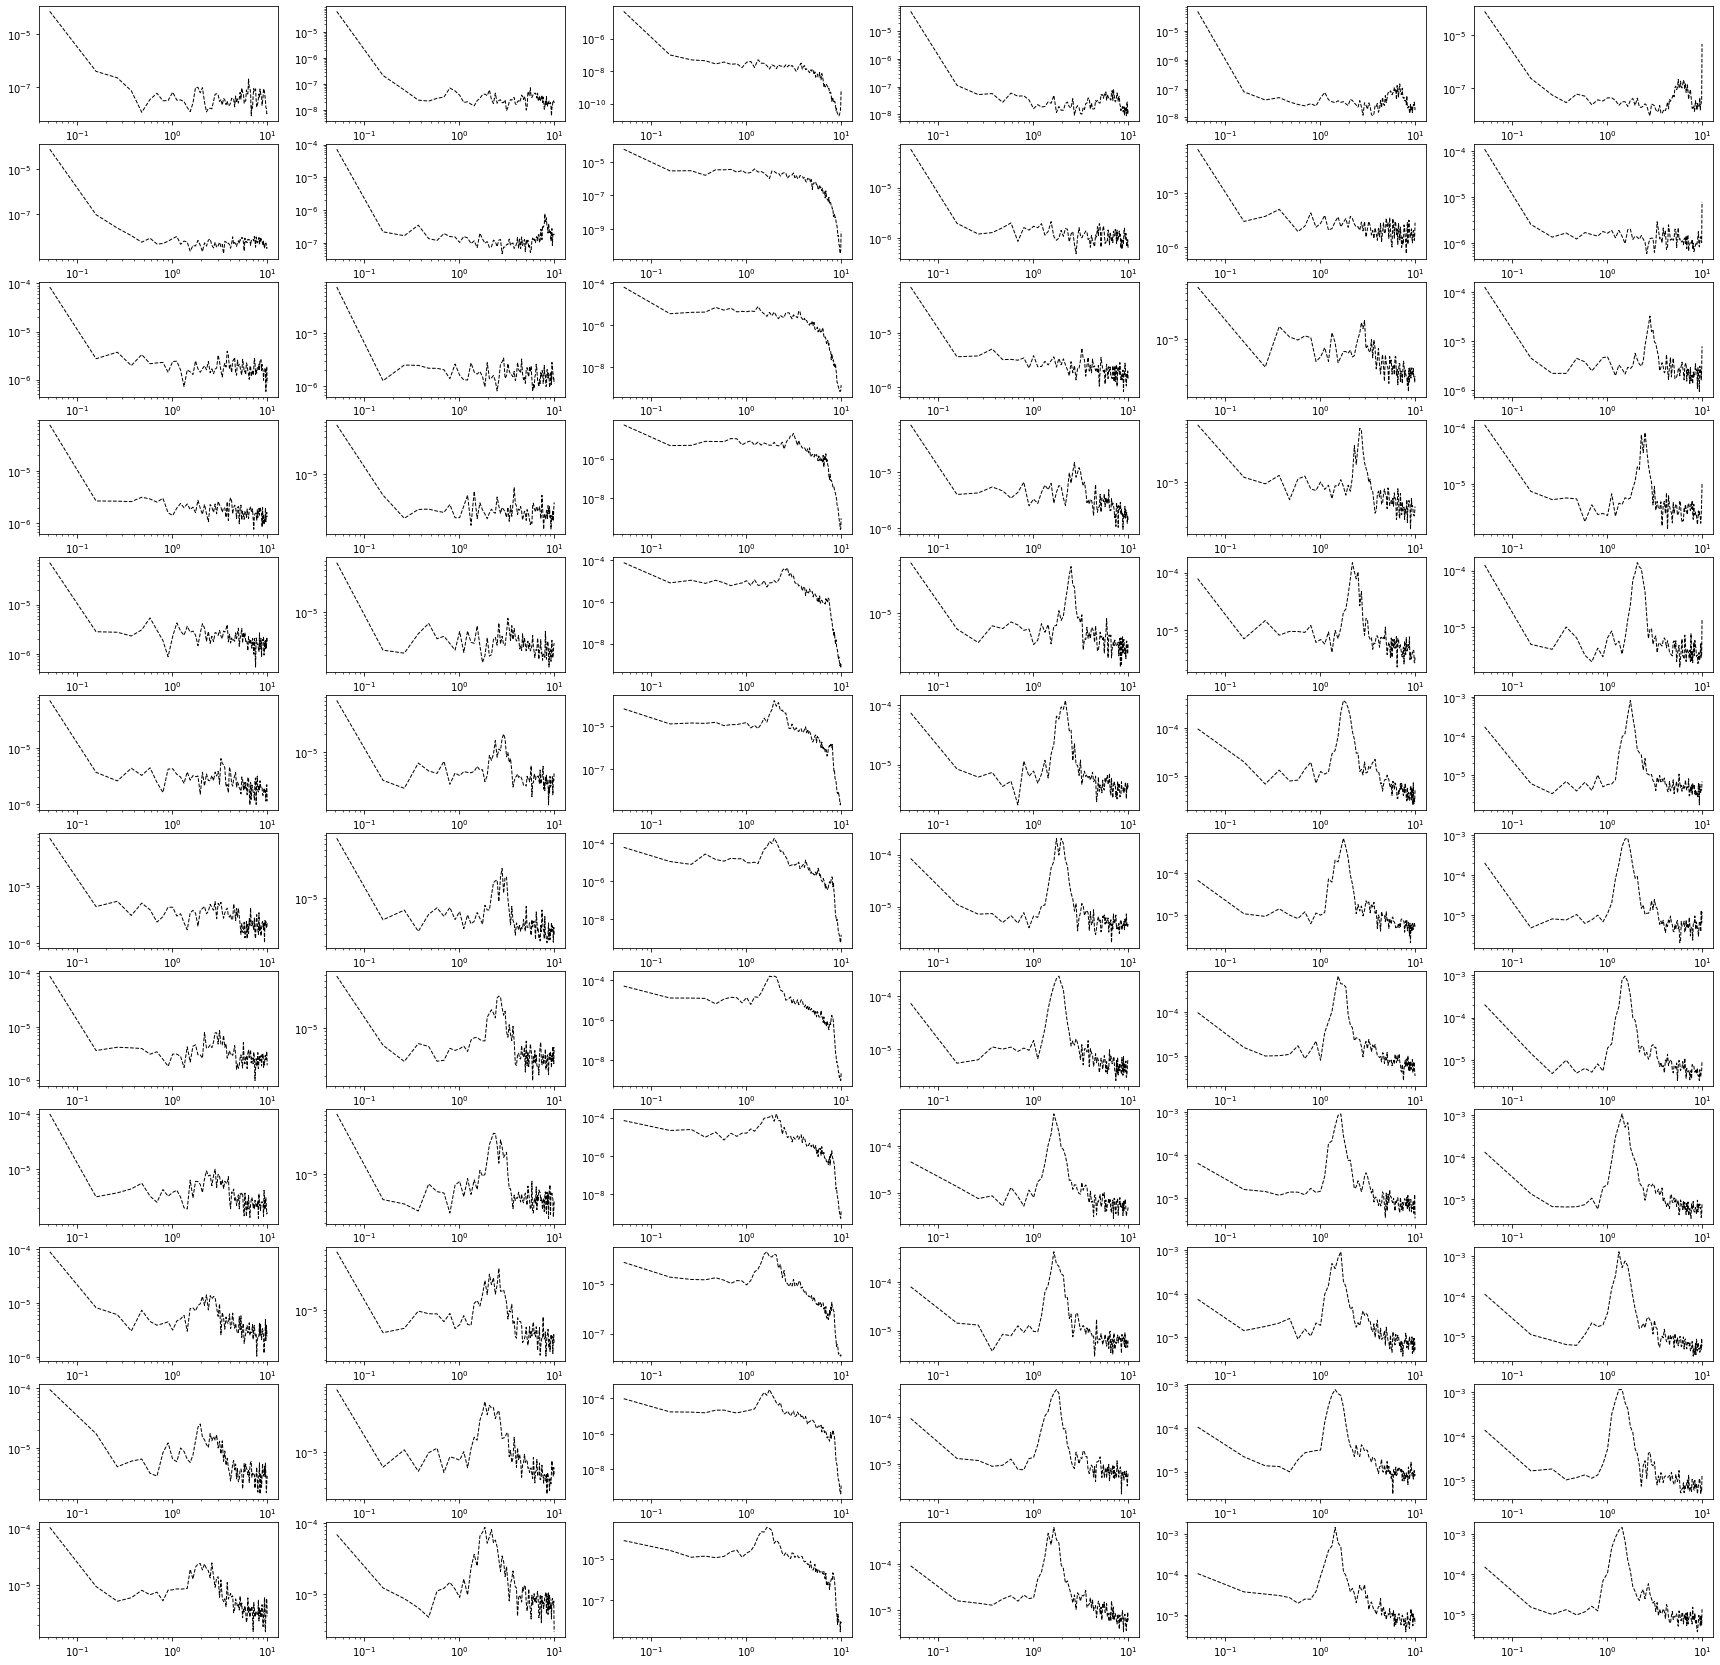

In [3]:



#define a function that derive wave number from frequency
def get_k_from_dis(omega,g,d):
    import sympy as sp
    import numpy as np
    x=sp.symbols("x")
    k=sp.nsolve(2*np.pi*omega**2/g-x*sp.tanh(x*d),1,prec=50) #Numerical Approach on wave number
    return k





run_seconds=6*60;
t_unit=0.05;
s_time=0;


t0 = [s_time + n * run_seconds + 60
    for n in range(len(fan))]
t1 = [s_time + (n + 1) * run_seconds
    for n in range(len(fan))]
Hs = np.zeros((12, 6))
Tp = np.zeros((12, 6))
Cpp = np.zeros((12, 6))
Cpm = np.zeros((12, 6))

Tm=Tp
time=np.array(time)
fan = range(0, 65, 5)
fig = plt.figure(figsize=(30, 30))



for n in range(1, len(fan)):
    print('Computing wave spectra for fan speed ', fan[n], 'Hz')
    mask = ((time) >= t0[n]) & ((time) <= t1[n])

  
    for i in range(6):
        ax = plt.subplot2grid((12, 6), (n - 1, i))
        e = detrend(elev[i,mask])
        F, f, df = power_spectrum(e, 1 / 20, binsize=32)
        ax.loglog(f, F, 'k--',lw=1)
        Hs[n-1,i] = 4 * np.sqrt(np.sum(F) * df)
        Tp[n-1,i] = np.sum(F**4) / np.sum(F**4 * f)
        Tm[n-1,i] = np.sum(F) / np.sum(F*f)
        k=np.zeros((len(f)))
        
        for j in range(1,len(f)):     
             k[j]=get_k_from_dis(f[j],9.81,.8)
        Cp=2*np.pi*f/k;
        Cpp[n-1,i]=np.sum(F[1:]**4 * Cp[1:]) / np.sum(F[1:]**4)
        Cpm[n-1,i]=np.sum(F[1:] * Cp[1:]) / np.sum(F[1:])

In [6]:
#get_stress from IRGASON:

   #self-defined function:

def diffc(x):
    """Finite difference centered in space."""
    xx = np.zeros((x.size))
    xx[1:-1] = (x[2:] - x[:-2]) / 2
    xx[0] = x[1] - x[0]
    xx[-1] = x[-1] - x[-2]
    return xx


def eddy_covariance_flux(u,v,w, time, t0, t1):
    """Eddy covariance flux from IRGASON, for a time subset between t0 and t1."""
    #mask = (time >= t0) & (time <= t1)
    #u, v, w = irg['u'][mask][:], irg['v'][mask][:], irg['w'][mask][:]
    u = np.sqrt(u**2 + v**2) # horizontal velocity
    angle = np.arctan2(np.nanmean(w), np.nanmean(u))
    u, w = rotate(u, w, angle)
    U, W = np.nanmean(u), np.nanmean(w) # time mean
    up, wp = u - U, w - W # deviations from the mean
    uw = np.nanmean(up * wp) # stress
    good = ~np.isnan(u) & ~np.isnan(w)
    perc_good = (u[good].size / u.size) * 100
    return U, uw, perc_good    
      



def sample_stress_uniform(irgason_data, time, start_time, run_seconds, sample_seconds, sampling):
    """Uniform-randomly sample IRGASON data and compute stress over given sample intervals."""
    num_runs, num_samples = sampling.shape
    U = np.zeros(sampling.shape)
    uw = np.zeros(sampling.shape)
    perc_good = np.zeros((num_runs, num_samples))
    for n in range(num_runs):
        #print('Computing stress for run', n)
        for i in range(num_samples):
            t0 = start_time + timedelta(seconds=n * run_seconds + sampling[n,i])
            t1 = t0 + timedelta(seconds=sample_seconds)
            U[n,i], uw[n,i], perc_good[n,i] = eddy_covariance_flux(irgason_data, time, t0, t1)
    return U, uw, perc_good

        

In [7]:
os.chdir('/Users/peisen/Downloads/sustain-lab-Curcic-Haus-2020-5e5ef93/data')
file3='asist-windonly-fresh.nc'
processed_fresh= netCDF4.Dataset(file3)
stress_irgason=(processed_fresh['stress_irgason'])

U_irgason=(processed_fresh['U_irgason'])



In [8]:
fan=range(0,65,5);

In [9]:
def trap(f0,f1,h):
    s=.5*h*(f0+f1)
    return s




In [12]:
def trap(f0,f1,h):
    s=.5*h*(f0+f1)
    return s
def jeffrey_sheltering(U,Cp,F,f,k,tau,rho_a):
    a=(tau*Cp)/rho_a
    integral=0
    for i in range(0,len(k)-1):
        
        h=k[i+1]-k[i]
        f1=F[i+1]*2*np.pi*f[i+1]*k[i+1]
        f0=F[i]*2*np.pi*f[i]*k[i]
        parameter=np.abs(U-Cp)*(U-Cp)
        s=trap(parameter*f0,parameter*f1,h)
        integral=integral+s
        
    A=a*1./integral
    return A


fan=range(0,65,5)
sf=20
length=sf*6*60;

A=np.zeros((13,6))

Hs = np.zeros((13, 6))
Tp = np.zeros((13, 6))
Cpp = np.zeros((13, 6))
Cpm = np.zeros((13, 6))

rho_air=1.225
Re=np.zeros((13,6))
vis_air=1.48 *10**(-5) 
U_irgason=np.array(U_irgason)

for n in range(1, len(fan)):
    
     
    for i in range(1,7,1):
        e = (elev[i-1,(n-1)*length+1:(n)*length])
        F, f, df = power_spectrum(e, 1 / 20, binsize=32)
        Hs[n-1,i-1] = 4 * np.sqrt(np.sum(F) * df)
        Tp[n-1,i-1] = np.sum(F**4) / np.sum(F**4 * f)
        Tm[n-1,i-1] = np.sum(F) / np.sum(F*f)
        k=np.zeros((len(f)))
        
        for j in range(1,len(f)):     
             k[j]=get_k_from_dis(f[j],9.81,.49)
                
        f_max=np.max(f);
        k_max=get_k_from_dis(f_max,9.81,.49)
        
        
        Cp=2*np.pi*f/k;
        
        Cp_max=2*np.pi*f_max/k_max
        
        Cpp[n-1,i-1]=np.sum(F[1:]**4 * Cp[1:]) / np.sum(F[1:]**4)
        Cpm[n-1,i-1]=np.sum(F[1:] * Cp[1:]) / np.sum(F[1:])
        A[n-1,i-1]=jeffrey_sheltering(U_irgason[n-1],Cpm[n-1,i-1],F,f,k,stress_irgason[n-1],rho_air)
        Re[n-1,i-1]=1./vis_air*(U_irgason[i-1]-Cp_max)*Hs[n-1,i-1]


Text(0.5, 0, 'Wind-speed(m/s)')

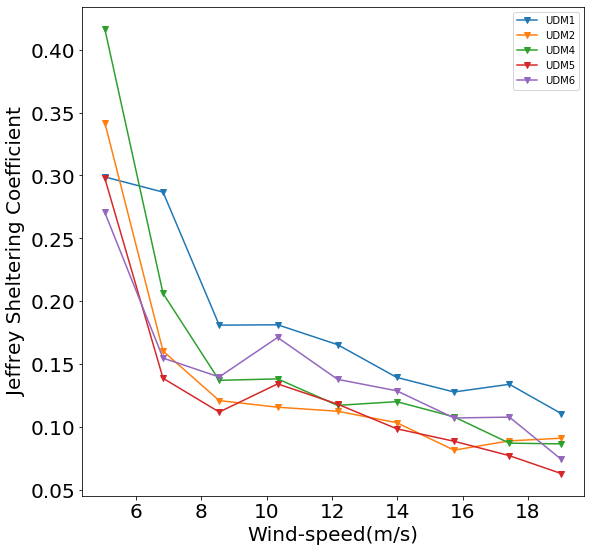

In [14]:
fig = plt.figure(figsize=(9, 9))
for i in range(1,7,1):
    if i==3:
        continue
    else:
        plt.plot(U_irgason[3:-1],A[3:-1,i-1],'-v')
plt.legend(('UDM1','UDM2','UDM4','UDM5','UDM6'))
plt.rc('xtick', labelsize=20)     
plt.rc('ytick', labelsize=20)
plt.ylabel('Jeffrey Sheltering Coefficient',size=20)
plt.xlabel('Wind-speed(m/s)',size=20)


(13, 6)


Text(0.5, 0, 'Wave Reynolds Number')

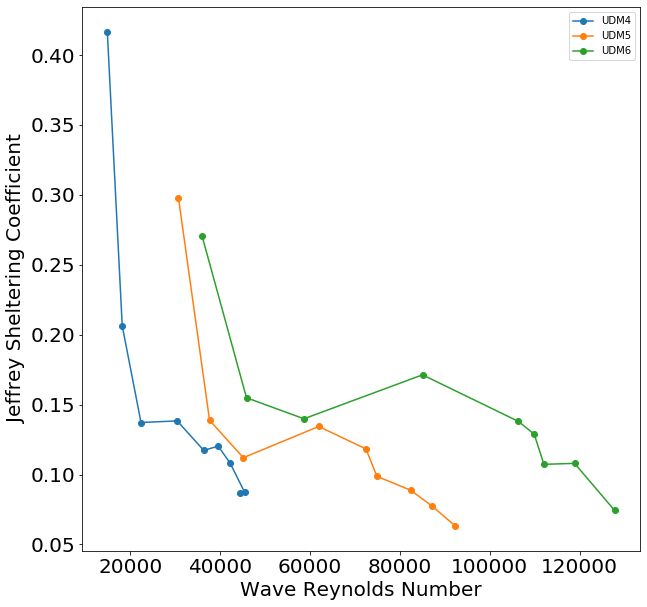

In [15]:
fig = plt.figure(figsize=(10, 10))
print(np.shape(A))
for i in range(1,7,1):
    if i<=3:
        continue
    else:
        plt.plot(Re[3:-1:,i-1],A[3:-1,i-1],'-o')
plt.legend(('UDM4','UDM5','UDM6'))
plt.rc('xtick', labelsize=20)     
plt.rc('ytick', labelsize=20)
plt.ylabel('Jeffrey Sheltering Coefficient',size=20)
plt.xlabel(('Wave Reynolds Number'),size=20)